# Trials with FeatUp
FeatUp is a framework for vision model feature upsampling.

In [1]:
%load_ext autoreload
%autoreload 2

from End2End_Model import End2End_Model
from DINO import VisionTransformer
from functools import partial
from torch import nn
import torch
from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Setup

Original `FeatUp` repository provides only pre-trained models and doesn't explain how to use their API with other models. </br>
Hovewer, this framework consist on separate ViT Backbone and Upscaler. Their ViT is backbone is enriched in few methods which enable features extraction. </br>
I reason that the simplest solution is to take my weights fine-tuned on LIDC and inject them into their ViT implementation.

In [2]:
# Creating an instance of FeatUp DINO ViTs16:
model = VisionTransformer(patch_size=16, 
                          embed_dim=384, 
                          depth=12, 
                          num_heads=6, 
                          mlp_ratio=4,
                          qkv_bias=True, 
                          norm_layer=partial(nn.LayerNorm, eps=1e-6))

I load checkpoint of a fine-tuned equivalent model and I extract `state_dict` weights from it.

In [4]:
ckpt_path="/home/jbinda/INFORM/LIDC_ViTs/ckpt/End2End/"+"dino_vits16_32_1.ckpt"

In [5]:
my_weights = torch.load(ckpt_path)

However, weights from my checkpoint has slightly different names/keys. There is need to rekey weights, to match an original architecture.

In [11]:
list(my_weights["state_dict"].keys())[:5]

['backbone.cls_token',
 'backbone.pos_embed',
 'backbone.patch_embed.proj.weight',
 'backbone.patch_embed.proj.bias',
 'backbone.blocks.0.norm1.weight']

In [12]:
# rekeying weights

rekeyed_weights = {}
for key in my_weights["state_dict"].keys():
    lst = key.split(".")
    if lst[0] == "backbone":
        new_key = ""
        for part in lst[1:]:
            new_key+=part+"."
        rekeyed_weights[new_key[:-1]] = my_weights["state_dict"][key]
    else:
        continue

In [14]:
list(rekeyed_weights.keys())[:5]

['cls_token',
 'pos_embed',
 'patch_embed.proj.weight',
 'patch_embed.proj.bias',
 'blocks.0.norm1.weight']

Finally, fine-tuned weights might be injected into their architecture:

In [15]:
model.load_state_dict(rekeyed_weights)

<All keys matched successfully>

## Inference

In [21]:
from my_utils.loading_data_utils import load_img
import os
import pickle
import matplotlib.pyplot as plt

In [22]:
current_directory = os.getcwd()
with open(current_directory+"/dataset/splitted_sets/fitted_factors.pkl", 'rb') as f:
    fitted_factors = pickle.load(f)

In [25]:
NODULE="0001.pt"

In [26]:
# Taking mean and std from fitted factors
MEAN, STD, SCALER = fitted_factors["fold_1"]
# Loading image from repository:
img, original_img = load_img(crop_path=current_directory + f"/dataset/crops/{NODULE}", 
                                 crop_view="axial", 
                                 slice_=16,
                                 MEAN=MEAN,
                                 STD=STD, 
                                 device="cuda")

In [38]:
original_img.shape

torch.Size([224, 224, 3])

Text(0.5, 1.0, 'FeatUp')

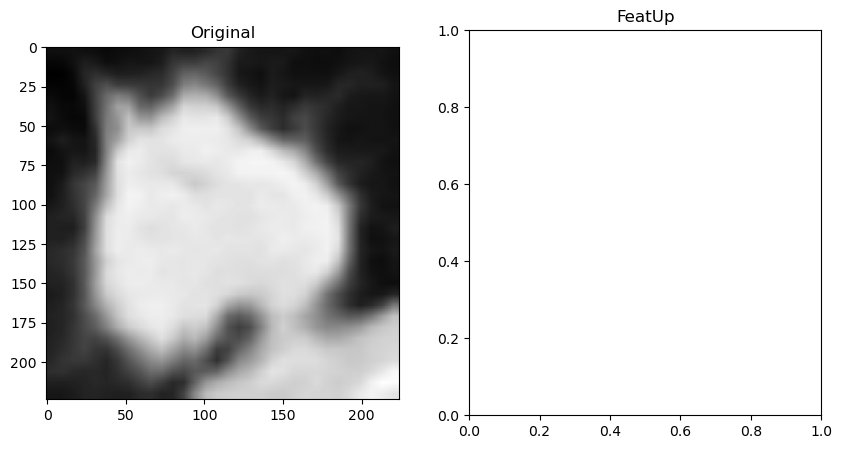

In [40]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(original_img[:,:,0], cmap="gray")
axs[0].set_title("Original")

#axs[1].
axs[1].set_title("FeatUp")